In [1]:
import os
import time
import pickle
from functools import partial

import numpy as np
import matplotlib.pyplot as plt

from src.qm_utils.lattice.lattice import Lattice2D
from src.qm_utils.lattice.brillouin_zone import BrillouinZone2D
from src.acband import acband_form_factors, hole_dispersion, K_func2

/root/acband-laughlin-instability/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
FIG_ROOT = "figs/solenoid_hole_dispersion_lp/"
DATA_ROOT = "data/solenoid_hole_dispersion_lp/"

os.makedirs(FIG_ROOT, exist_ok=True)
os.makedirs(DATA_ROOT, exist_ok=True)

In [ ]:
# K = 0.8
m = 3
sigma_to_scan = np.arange(0.05, 2.01, 0.05)
sum_radius = 10.0

sqrt3 = 3.0 ** 0.5
a_M = 1
lB = ((sqrt3 / (4 * m * np.pi)) ** 0.5) * a_M
# lB = ((sqrt3 / (4 * np.pi)) ** 0.5) * a_M

fourier_resolution = 128
G_radius = 32

e1 = np.array([1, 0])
e2 = np.array([0, 1])
a1 = a_M * e2
a2 = a_M * ((-sqrt3 / 2) * e1 + (1 / 2) * e2)
lattice = Lattice2D(np.stack([a1, a2]))
recip_lattice = lattice.reciprocal()

In [4]:
b1, b2 = lattice.reciprocal_lattice_vectors
b3 = -(b1 + b2)

c1 = (1 / 3) * (b1 - b2)
c2 = (1 / 3) * (b1 - b3)
c3 = (1 / 3) * (b2 - b3)

N = 6

t1 = c1 / (2 * N)
t2 = c2 / (2 * N)

V1 = 1.0
# v1 = 3 * V1 * (a_M ** 4) / (4 * np.pi)
v1 = 3 * V1 * (a_M ** 4) / (8 * np.pi)

def V(q):
    return -v1 * np.linalg.norm(q, axis=-1) ** 2

sample_lattice = Lattice2D(np.stack([t1, t2]))
bz = BrillouinZone2D(lattice, sample_lattice)

In [5]:
coords_m_gamma_k_m = np.array(
    [
        [n, n] for n in range(N, 0, -1)
    ] + [
        [0, n] for n in range(0, 2 * N, 1)
    ] + [
        [n, 2 * N - n] for n in range(0, N + 1, 1)
    ] 
)
indices_m_gamma_k_m = np.array(
    [bz.idx_from_coord[tuple(coord.tolist())] for coord in coords_m_gamma_k_m]
)
points_m_gamma_k_m = bz.k_points[indices_m_gamma_k_m]
path_tick_indices = np.array([0, N, 3 * N, 4 * N])
path_tick_labels = [r'$M$', r'$\Gamma$', r'$K$', r'$M$']
length_along_path = np.zeros(points_m_gamma_k_m.shape[0])
for i in range(1, length_along_path.shape[0]):
    dk = points_m_gamma_k_m[i] - points_m_gamma_k_m[i - 1]
    length_along_path[i] = length_along_path[i - 1] + np.linalg.norm(dk)

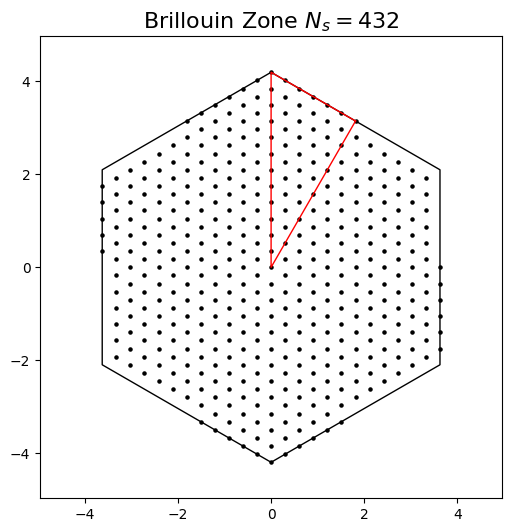

In [6]:
b = (4 * np.pi) / (a_M * sqrt3)
R = b / sqrt3
thetas = np.linspace(np.pi / 2, 5 * np.pi / 2, 7)
hexagon_x = R * np.cos(thetas)
hexagon_y = R * np.sin(thetas)

k_points = bz.k_points

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot()
ax.set_title(f"Brillouin Zone $N_s={bz.N_s}$", fontsize=16)
ax.set_aspect('equal')
k_x = k_points[:, 0]
k_y = k_points[:, 1]
ax.plot(hexagon_x, hexagon_y, color='k', linewidth=1)
ax.scatter(k_x, k_y, s=5, c='k')
path_x = points_m_gamma_k_m[:, 0]
path_y = points_m_gamma_k_m[:, 1]
ax.plot(path_x, path_y, color='r', linewidth=1)
# for i in range(bz.N_s):
#     x = k_x[i]
#     y = k_y[i]
#     ax.text(x, y, f"{i}", fontsize=8, color="w", ha='center', va='center')
ax.set_xlim(-36 / b, 36 / b)
ax.set_ylim(-36 / b, 36 / b)
plt.show()

In [7]:
band_widths = np.zeros_like(sigma_to_scan)

In [ ]:
for sigma_idx, sigma in enumerate(sigma_to_scan):
    K_func_args = (m, sigma, sum_radius, a1, a2)
    K_func = partial(K_func2, args=K_func_args)

    start = time.time()
    try:
        G_coords, ac_ff = acband_form_factors(
            bz,
            lB,
            K_func,
            fourier_resolution,
            G_radius=G_radius,
            fft=True
        )
        dispersion = hole_dispersion(
            bz,
            G_coords,
            ac_ff,
            V,
        )
        band_width = np.max(dispersion) - np.min(dispersion)
        band_widths[sigma_idx] = band_width
    except Exception as e:
        end = time.time()
        print(f"Error for sigma={sigma:.2f} in {end - start:.2f} seconds: {e}")
        band_widths[sigma_idx] = np.nan
        continue
    end = time.time()
    print(f"Sigma: {sigma:.2f}, Time taken: {end - start:.2f} seconds")
    print(f"Band width: {band_width / V1:.4f} V1")
    fig_path = os.path.join(FIG_ROOT, f"{sigma:.3f}.png")
    
    dispersion_along_path = dispersion[indices_m_gamma_k_m]
    plt.figure(figsize=(5, 4))
    plt.plot(length_along_path, dispersion_along_path - np.min(dispersion_along_path))
    plt.xticks(length_along_path[path_tick_indices], path_tick_labels)
    plt.ylabel("$\\epsilon(k) / V_1$")
    plt.title(f"Interaction-Induced Hole Dispersion ($\\sigma={sigma:.3f}$)")
    plt.savefig(fig_path)
    plt.close()

    data_path = os.path.join(DATA_ROOT, f"dispersion_{sigma:.3f}.pkl")
    with open(data_path, "wb") as f:
        pickle.dump({
            "bz": bz,
            "k_points": bz.k_points,
            "dispersion": dispersion,
            "length_along_path": length_along_path,
            "path_tick_indices": path_tick_indices,
            "path_tick_labels": path_tick_labels,
            "dispersion_along_path": dispersion_along_path,
        }, f)
        
np.save(os.path.join(DATA_ROOT, "band_widths.npy"), band_widths)

/root/acband-laughlin-instability/src/acband.py:76: RuntimeWarning: divide by zero encountered in log
  chis = np.where(dists < 1, (dists_square - 1) / 2, np.log(dists))


Error for sigma=0.05 in 48.96 seconds: Hartree energies have significant imaginary parts: 0.010917086746221934
Error for sigma=0.10 in 59.45 seconds: Hartree energies have significant imaginary parts: 1.1354727840802702e-05
Error for sigma=0.15 in 53.88 seconds: Hartree energies have significant imaginary parts: 9.969167177602071e-06
Error for sigma=0.20 in 50.36 seconds: Hartree energies have significant imaginary parts: 3.94701279788267e-06
Error for sigma=0.25 in 60.95 seconds: Hartree energies have significant imaginary parts: 4.778311176774429e-06
Error for sigma=0.30 in 1.04 seconds: Normalization constants have non-positive real parts: -0.12301539786200613
Error for sigma=0.35 in 1.07 seconds: Normalization constants have non-positive real parts: -0.05313039358104181
Sigma: 0.40, Time taken: 120.17 seconds
Band width: 15.8411 V1


/root/acband-laughlin-instability/src/acband.py:76: RuntimeWarning: divide by zero encountered in log
  chis = np.where(dists < 1, (dists_square - 1) / 2, np.log(dists))


Sigma: 0.45, Time taken: 138.86 seconds
Band width: 13.5305 V1


/root/acband-laughlin-instability/src/acband.py:76: RuntimeWarning: divide by zero encountered in log
  chis = np.where(dists < 1, (dists_square - 1) / 2, np.log(dists))


Sigma: 0.50, Time taken: 127.00 seconds
Band width: 8.4294 V1


/root/acband-laughlin-instability/src/acband.py:76: RuntimeWarning: divide by zero encountered in log
  chis = np.where(dists < 1, (dists_square - 1) / 2, np.log(dists))


Sigma: 0.55, Time taken: 163.01 seconds
Band width: 6.6600 V1


/root/acband-laughlin-instability/src/acband.py:76: RuntimeWarning: divide by zero encountered in log
  chis = np.where(dists < 1, (dists_square - 1) / 2, np.log(dists))


Sigma: 0.60, Time taken: 169.63 seconds
Band width: 5.8054 V1


/root/acband-laughlin-instability/src/acband.py:76: RuntimeWarning: divide by zero encountered in log
  chis = np.where(dists < 1, (dists_square - 1) / 2, np.log(dists))


Sigma: 0.65, Time taken: 167.39 seconds
Band width: 5.2599 V1


/root/acband-laughlin-instability/src/acband.py:76: RuntimeWarning: divide by zero encountered in log
  chis = np.where(dists < 1, (dists_square - 1) / 2, np.log(dists))


In [ ]:
K_func_args = (m, 0.5, sum_radius, a1, a2)
K_func = partial(K_func2, args=K_func_args)


start = time.time()
G_coords, ac_ff = acband_form_factors(
    bz,
    lB,
    K_func,
    fourier_resolution,
    G_radius=G_radius,
    fft=True
)
end = time.time()
print(f"Form factor computation time: {end - start:.4f} seconds")

V1 = 1.0
# v1 = 3 * V1 * (a_M ** 4) / (4 * np.pi)
v1 = 3 * V1 * (a_M ** 4) / (8 * np.pi)

def V(q):
    return -v1 * np.linalg.norm(q, axis=-1) ** 2

start = time.time()
dispersion = hole_dispersion(
    bz,
    G_coords,
    ac_ff,
    V,
)
end = time.time()
print(f"Hole dispersion computation time: {end - start:.4f} seconds")

band_width = np.max(dispersion) - np.min(dispersion)

/root/acband-laughlin-instability/src/acband.py:76: RuntimeWarning: divide by zero encountered in log
  chis = np.where(dists < 1, (dists_square - 1) / 2, np.log(dists))


Form factor computation time: 27.5274 seconds
Hole dispersion computation time: 27.5006 seconds


In [ ]:
dispersion_along_path = dispersion[indices_m_gamma_k_m]


Band width: 8.4294 V1


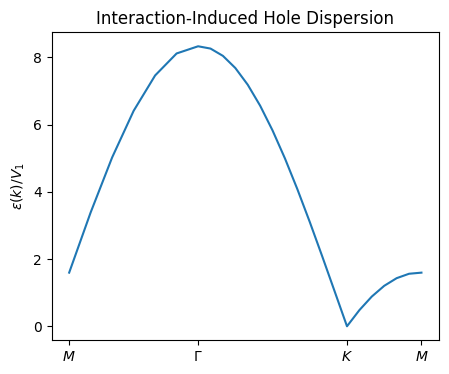

In [ ]:
plt.figure(figsize=(5, 4))
plt.plot(length_along_path, dispersion_along_path - np.min(dispersion_along_path))
plt.xticks(length_along_path[path_tick_indices], path_tick_labels)
plt.ylabel("$\\epsilon(k) / V_1$")
plt.title("Interaction-Induced Hole Dispersion")
print(f"Band width: {band_width / V1:.4f} V1")
plt.show()